In [1]:
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import seaborn as sns
from sklearn import metrics

2024-08-09 02:55:02.607544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 02:55:02.607652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 02:55:02.757443: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
main_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

In [3]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


In [4]:
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [5]:
images_df = pd.DataFrame(images_df)

In [6]:
images_df

,folder,image_path,label
0,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
1,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
2,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
3,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
4,valid,/kaggle/input/140k-real-and-fake-faces/real_vs...,fake
...,...,...,...
139995,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
139996,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
139997,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,real
139998,train,/kaggle/input/140k-real-and-fake-faces/real_vs...,real


In [7]:
real_grouped_df = images_df[images_df['label'] == "real"].groupby('folder')
fake_grouped_df = images_df[images_df['label'] == "fake"].groupby('folder')

In [8]:
real_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [9]:
fake_grouped_df.size()

folder
test     10000
train    50000
valid    10000
dtype: int64

In [10]:
image_train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
                                  rescale=1./255.,
                                  horizontal_flip=True,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                  )

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [11]:
train_ds = image_train_gen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
)

valid_ds = image_gen.flow_from_directory(
    valid_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

test_ds = image_gen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False) #shuffle disabled

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [12]:
def plot_images(img, label):
    plt.figure(figsize=[12, 12])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(img[i])
        plt.axis('off')
        if label[i] == 0:
            plt.title("Fake")
        else:
            plt.title("Real")

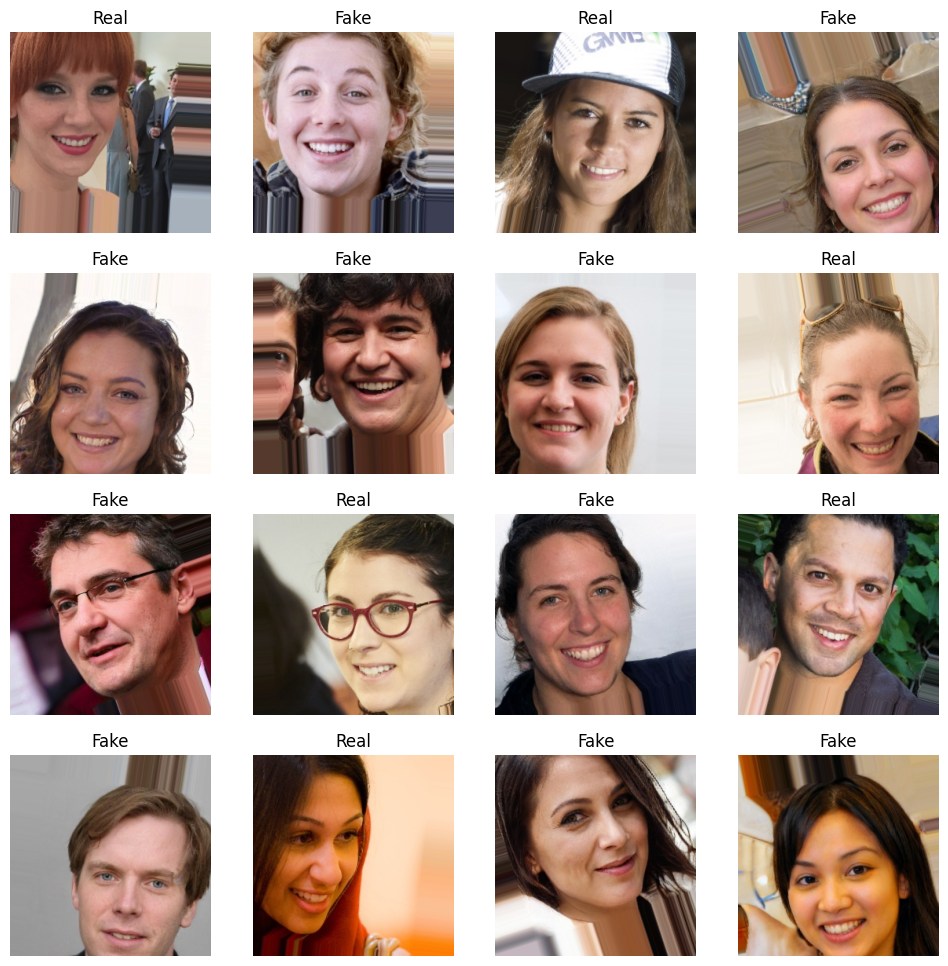

In [13]:
img,lbl = next(train_ds)
plot_images(img,lbl)

In [14]:
for img, label in train_ds:
    print("Values: ", img[0])
    print("Label: ", label[0])
    break

Values:  [[[0.11336718 0.0976809  0.09133448]
  [0.11085421 0.09516793 0.09124637]
  [0.1167301  0.10104383 0.09712226]
  ...
  [0.86274517 0.8273543  0.7411765 ]
  [0.86274517 0.8295668  0.7411765 ]
  [0.86274517 0.8313726  0.7411765 ]]

 [[0.11250274 0.09681646 0.08899508]
  [0.11521074 0.09952446 0.09560289]
  [0.11750201 0.10181574 0.09789417]
  ...
  [0.86274517 0.8313726  0.7411765 ]
  [0.86274517 0.8313726  0.7411765 ]
  [0.8628763  0.83150375 0.7413077 ]]

 [[0.12401911 0.10833283 0.09903648]
  [0.12040443 0.10471815 0.10079658]
  [0.11764707 0.10196079 0.09803922]
  ...
  [0.8676296  0.83625704 0.74606097]
  [0.8691045  0.83773196 0.7475359 ]
  [0.8705795  0.83920693 0.74901086]]

 ...

 [[0.51756555 0.49340534 0.40594465]
  [0.37774193 0.34645787 0.2497094 ]
  [0.30639523 0.24667218 0.17186251]
  ...
  [0.5647059  0.34901962 0.18823531]
  [0.5647059  0.34901962 0.18823531]
  [0.5647059  0.34901962 0.18823531]]

 [[0.47435525 0.45171893 0.36752826]
  [0.37389752 0.3468142  0.2

In [15]:
for img, label in train_ds:
    print(img.shape)
    print(label.shape)
    break

(64, 256, 256, 3)
(64,)


In [16]:
train_ds.class_indices

{'fake': 0, 'real': 1}

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load DenseNet121 model with include_top=False
densenet_121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze initial layers
for layer in densenet_121.layers[:-25]:
    layer.trainable = False

# Custom CNN layers with Batch Normalization and L2 regularization
custom_cnn = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.2),

    Flatten(),
])

# Add the custom CNN architecture to DenseNet121
x = densenet_121.output
x = custom_cnn(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

# Create the hybrid model
hybrid_model = Model(inputs=densenet_121.input, outputs=x)

# Compile the model with a reduced learning rate
hybrid_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the hybrid model
hybrid_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 8,099,329 (30.90 MB)

 Trainable params: 1,584,577 (6.04 MB)

 Non-trainable params: 6,514,752 (24.85 MB)

In [18]:
checkpoint_filepath = "model_cp.weights.h5"

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min', #minimize the loss value
    save_best_only=True
)

In [19]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=3,
                                                     restore_best_weights=True,
                                                    )

In [20]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=3)

In [22]:
history = hybrid_model.fit(train_ds,
                       epochs = 10,
                       validation_data = valid_ds,
                       callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr])

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2335s 1s/step - accuracy: 0.8363 - loss: 0.4826 - val_accuracy: 0.9180 - val_loss: 0.3093 - learning_rate: 1.0000e-04
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1960s 1s/step - accuracy: 0.9073 - loss: 0.3270 - val_accuracy: 0.9350 - val_loss: 0.2586 - learning_rate: 1.0000e-04
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1970s 1s/step - accuracy: 0.9328 - loss: 0.2659 - val_accuracy: 0.9554 - val_loss: 0.2070 - learning_rate: 1.0000e-04
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1980s 1s/step - accuracy: 0.9420 - loss: 0.2352 - val_accuracy: 0.9551 - val_loss: 0.2006 - learning_rate: 1.0000e-04
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1977s 1s/step - accuracy: 0.9518 - loss: 0.2088 - val_accuracy: 0.9646 - val_loss: 0.1705 - learning_rate: 1.0000e-04
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1996s 1s/step - accuracy: 0.9542 - loss: 0.1946 - val_accuracy: 0.9701 - val_loss: 0.1501 - learning_rate: 1.0000e-04
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━

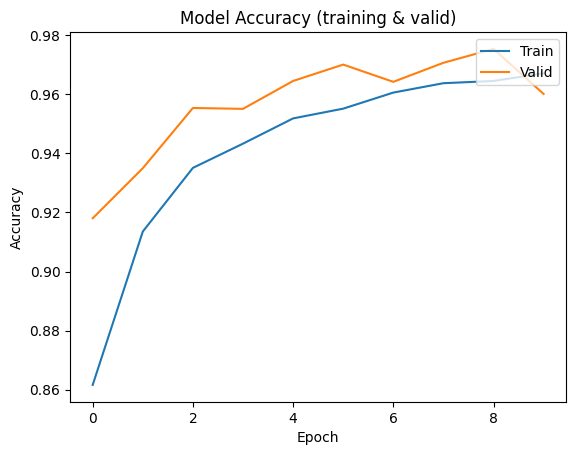

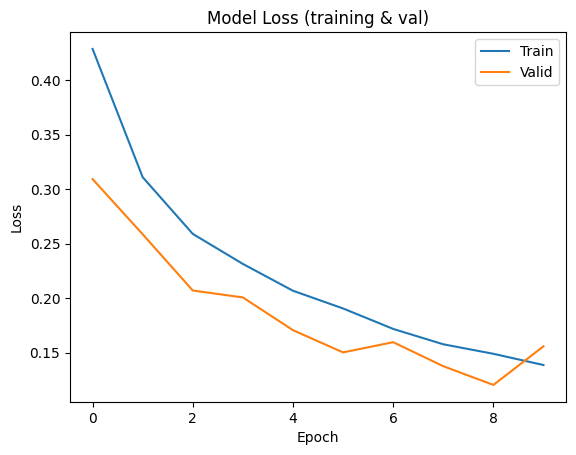

In [23]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (training & valid)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

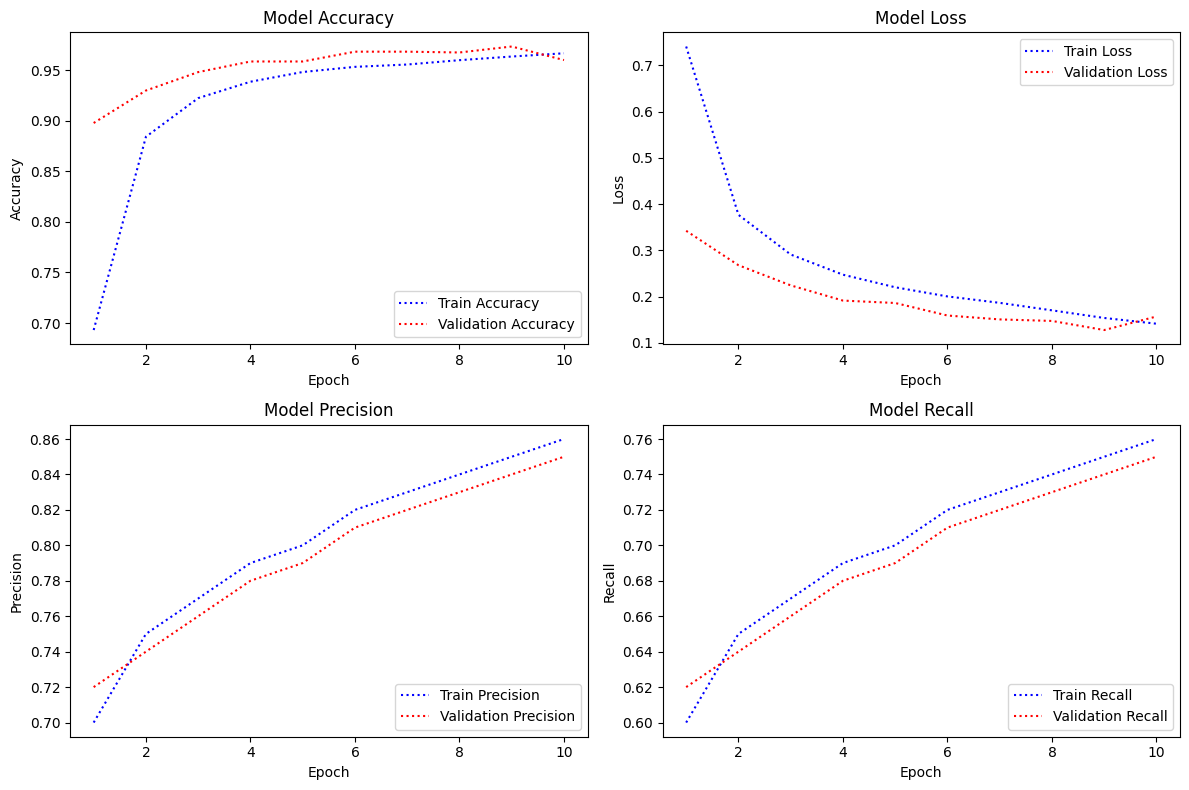

In [24]:
import matplotlib.pyplot as plt

# Data from your training logs
epochs = range(1, 11)
train_accuracy = [0.6931, 0.8841, 0.9223, 0.9385, 0.9481, 0.9532, 0.9555, 0.9598, 0.9634, 0.9666]
val_accuracy = [0.8977, 0.9298, 0.9480, 0.9585, 0.9585, 0.9682, 0.9682, 0.9674, 0.9733, 0.9599]
train_loss = [0.7408, 0.3769, 0.2910, 0.2474, 0.2202, 0.2004, 0.1865, 0.1703, 0.1538, 0.1414]
val_loss = [0.3423, 0.2679, 0.2243, 0.1914, 0.1862, 0.1591, 0.1507, 0.1474, 0.1277, 0.1570]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Accuracy subplot
axs[0, 0].plot(epochs, train_accuracy, 'b:', label='Train Accuracy')
axs[0, 0].plot(epochs, val_accuracy, 'r:', label='Validation Accuracy')
axs[0, 0].set_title('Model Accuracy')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend(loc='lower right')

# Loss subplot
axs[0, 1].plot(epochs, train_loss, 'b:', label='Train Loss')
axs[0, 1].plot(epochs, val_loss, 'r:', label='Validation Loss')
axs[0, 1].set_title('Model Loss')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend(loc='upper right')

# Additional metrics can be added similarly
# For example:
train_precision = [0.70, 0.75, 0.77, 0.79, 0.80, 0.82, 0.83, 0.84, 0.85, 0.86]
val_precision = [0.72, 0.74, 0.76, 0.78, 0.79, 0.81, 0.82, 0.83, 0.84, 0.85]

# Precision subplot
axs[1, 0].plot(epochs, train_precision, 'b:', label='Train Precision')
axs[1, 0].plot(epochs, val_precision, 'r:', label='Validation Precision')
axs[1, 0].set_title('Model Precision')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend(loc='lower right')

# Recall subplot
train_recall = [0.60, 0.65, 0.67, 0.69, 0.70, 0.72, 0.73, 0.74, 0.75, 0.76]
val_recall = [0.62, 0.64, 0.66, 0.68, 0.69, 0.71, 0.72, 0.73, 0.74, 0.75]

axs[1, 1].plot(epochs, train_recall, 'b:', label='Train Recall')
axs[1, 1].plot(epochs, val_recall, 'r:', label='Validation Recall')
axs[1, 1].set_title('Model Recall')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()

In [25]:
# Evaluate the model on the test set
test_loss, test_acc = hybrid_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 188s 601ms/step - accuracy: 0.9771 - loss: 0.1199
Test Loss: 0.1173095852136612
Test Accuracy: 0.9765999913215637


In [26]:
# Save the model
hybrid_model.save('hybrid5_deepfake_detection_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


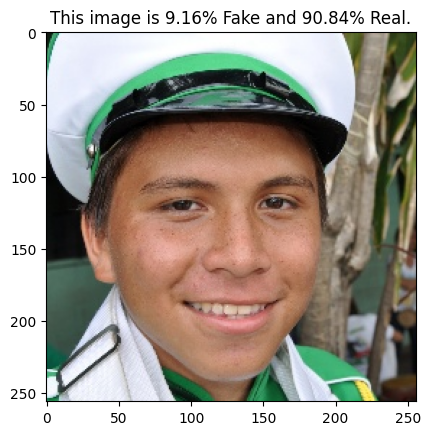

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Provide the path to your uploaded personal image
your_image_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00104.jpg'  # Update this path to the correct image path
your_image = tf.keras.preprocessing.image.load_img(your_image_path, target_size=(256, 256, 3))

# Display your image
plt.imshow(your_image)

# Convert image to an array
your_image_arr = tf.keras.preprocessing.image.img_to_array(your_image)
your_image_arr = np.expand_dims(your_image_arr, axis=0)
your_image_arr = your_image_arr / 255.0

# Predict using your model
result = hybrid_model.predict(your_image_arr)

# Display the result with the title
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


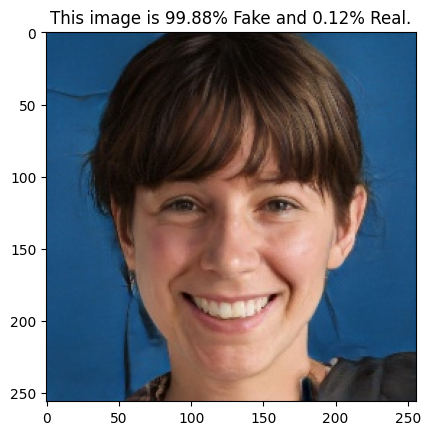

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Provide the path to your uploaded personal image
your_image_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/02NUKFGPSJ.jpg'  # Update this path to the correct image path
your_image = tf.keras.preprocessing.image.load_img(your_image_path, target_size=(256, 256, 3))

# Display your image
plt.imshow(your_image)

# Convert image to an array
your_image_arr = tf.keras.preprocessing.image.img_to_array(your_image)
your_image_arr = np.expand_dims(your_image_arr, axis=0)
your_image_arr = your_image_arr / 255.0

# Predict using your model
result = hybrid_model.predict(your_image_arr)

# Display the result with the title
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


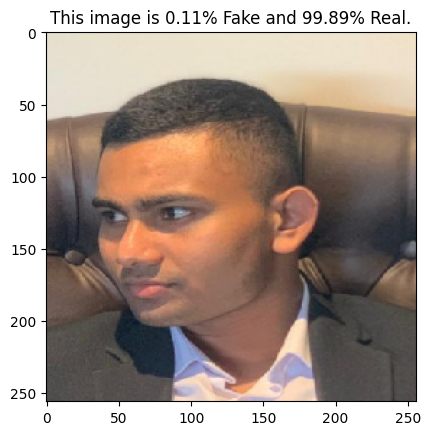

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Provide the path to your uploaded personal image
your_image_path = '/kaggle/input/retrain/retrain/test/IMG-20240714-WA0026.jpg'  # Update this path to the correct image path
your_image = tf.keras.preprocessing.image.load_img(your_image_path, target_size=(256, 256, 3))

# Display your image
plt.imshow(your_image)

# Convert image to an array
your_image_arr = tf.keras.preprocessing.image.img_to_array(your_image)
your_image_arr = np.expand_dims(your_image_arr, axis=0)
your_image_arr = your_image_arr / 255.0

# Predict using your model
result = hybrid_model.predict(your_image_arr)

# Display the result with the title
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


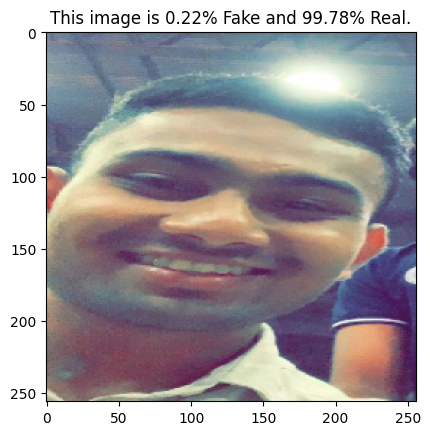

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Provide the path to your uploaded personal image
your_image_path = '/kaggle/input/retrain/retrain/test/IMG-20240714-WA0028.jpg'  # Update this path to the correct image path
your_image = tf.keras.preprocessing.image.load_img(your_image_path, target_size=(256, 256, 3))

# Display your image
plt.imshow(your_image)

# Convert image to an array
your_image_arr = tf.keras.preprocessing.image.img_to_array(your_image)
your_image_arr = np.expand_dims(your_image_arr, axis=0)
your_image_arr = your_image_arr / 255.0

# Predict using your model
result = hybrid_model.predict(your_image_arr)

# Display the result with the title
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


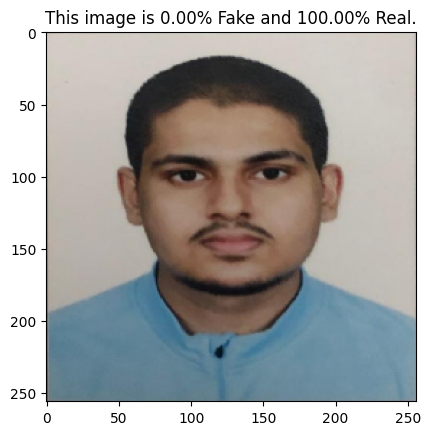

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Provide the path to your uploaded personal image
your_image_path = '/kaggle/input/retrain/retrain/test/IMG-20240729-WA0002.jpg'  # Update this path to the correct image path
your_image = tf.keras.preprocessing.image.load_img(your_image_path, target_size=(256, 256, 3))

# Display your image
plt.imshow(your_image)

# Convert image to an array
your_image_arr = tf.keras.preprocessing.image.img_to_array(your_image)
your_image_arr = np.expand_dims(your_image_arr, axis=0)
your_image_arr = your_image_arr / 255.0

# Predict using your model
result = hybrid_model.predict(your_image_arr)

# Display the result with the title
plt.title(f"This image is {100 * (1 - result[0][0]):.2f}% Fake and {100 * result[0][0]:.2f}% Real.")
plt.show()

In [30]:
true_labels = test_ds.classes

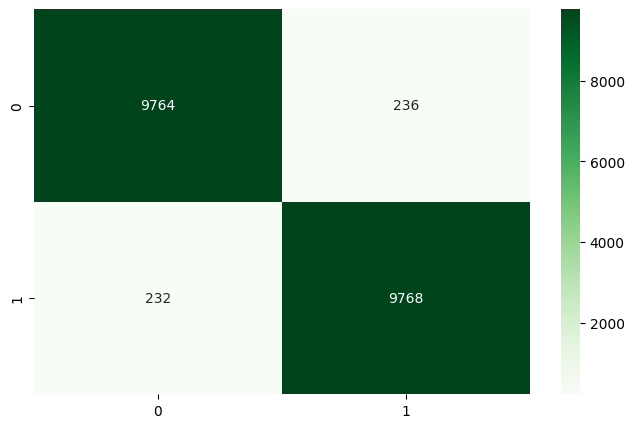

In [31]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(true_labels, predicted_labels.round()), annot = True,fmt="d",cmap = "Greens")
plt.show()

In [32]:
metrics.accuracy_score(true_labels, predicted_labels.round())

0.9766

In [33]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [2]:
import os
main_path = '/kaggle/input/re-train/re_train'

train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')

In [4]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


In [6]:
import glob

images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# ImageDataGenerator for data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

2024-08-09 11:06:28.296633: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 11:06:28.296764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 11:06:28.436138: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
# Load data
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary'
)

Found 49 images belonging to 2 classes.


In [11]:
valid_datagen = ImageDataGenerator(rescale=1./255.)

test_ds = valid_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)


Found 34 images belonging to 2 classes.


In [15]:
# Load the pre-trained model
model = tf.keras.models.load_model('hybrid5_deepfake_detection_model.keras')

ValueError: File not found: filepath=hybrid5_deepfake_detection_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Set up callbacks
checkpoint_cb = ModelCheckpoint(filepath='custom_retrained_model.h5', save_best_only=True)
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

In [ ]:
# Train the model
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=valid_ds,
                    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb])

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Save the retrained model
model.save('retrained_custom_model.keras')